<center>
<h1><br/></h1>
<h1>CSC_52081_EP lab8 bis: VAEs for MNIST digits generation</h1>
<br>
</center>

The goal of this notebook is to present the basics of variational auto-encoders (VAEs), on some toy datasets so that training is not too long.


## Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself).

In [ ]:
info = {
    "Email": "firstname.lastname@polytechnique.edu",
    "Alias": "Anonymous",  # (change this in case you want to identify yourself on the leaderboard)
}


The notebook deals with variational auto-encoder (VAE). It is based on code from a <a href="https://dataflowr.github.io/website/">course of Marc Lelarge</a>, which itself borrows from existing classical implementations of VAEs in PyTorch that can be found [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65).



We will use MNIST dataset and a basic VAE architecture.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size))
    except:
        out, _, _ = model(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, z_dim=2, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            z = torch.randn(n*n_classes, z_dim).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            concat_input = torch.cat([z, y_onehot], 1)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out, n).cpu()
    show(out_grid)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Brief reminder on variational autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

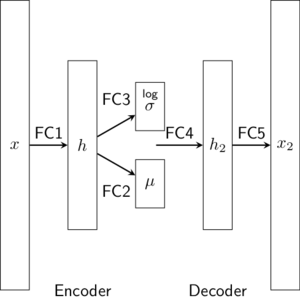

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [ ]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

In [ ]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

In [ ]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. The rest of this task is to explore one solution (a conditional VAE (CVAE)) to generates zeroes, ones, twos and so on.

# <font color="red">Task</font>: implement a conditional VAE

Implement a conditional VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that the encoder is now conditioned to two variables X and c: $q_{\theta}(z|X,c)$ while the decoder is conditioned to the variables z ad c: $p_{\theta}(X|z,c)$. Now, the real latent variable is distributed under $p(z|c)$.

The conditional VAE was proposed by [(Sohn et al., 2015)](https://papers.nips.cc/paper/2015/hash/8d55a249e6baa5c06772297520da2051-Abstract.html) and is explained in the tutorial [(Doersch, 2016)](https://arxiv.org/abs/1606.05908).

<font color="red">Task</font>: Implement a class CVAE and its training by making minimal changes to the VAE code above. You can use the function plot_conditional_generation above to test your code. For instance, plot_conditional_generation(cvae, fix_number=3) should plot 8 images in the same row with independent generations of the number 3.

Your are free to modify the network structure and the training parameters as long as training remains reasonable and you should try to obtain decent digits generation. Besides this, make minimal changes to the code above.

Please use the code above to load the data, it checks if the data is not already present before downloading it. For ecological reasons, we will make sure to run your code in a folder that already contains the data.  

Note: you will need to add "n_classes = 10" as this variables is used in the function "plot_conditional_generation".


In [ ]:
n_classes = 10

class CVAE(nn.Module):
    # TODO: implement the class CVAE by implementing the methods
    # __init__, encode, reparameterize, decode, forward
    # 

# TODO: build model
# 
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


In [ ]:
# TODO: train the model
# 

The following commands should then print the results generated.

In [ ]:
#print a grid with each digit in a row (8 images of each digit per row)
plot_conditional_generation(cvae, n=8, z_dim=4, fix_number=None)
#print a line with just a row of digit 2 (8 images)
plot_conditional_generation(cvae, n=8, z_dim=4, fix_number=2)
